In [38]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [39]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [40]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1']:
            if row['SPREAD'] > row['SPREAD_1']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1']:
            if row['SPREAD'] < row['SPREAD_1']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2']:
            if row['SPREAD'] > row['SPREAD_2']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2']:
            if row['SPREAD'] < row['SPREAD_2']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4']:
            if row['SPREAD'] > row['SPREAD_4']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4']:
            if row['SPREAD'] < row['SPREAD_4']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [41]:
def eval_model(model):
    #create df of actual spreads, predicted spreads, and betting spreads
    spread_eval_df = test_spreads_df.copy()
    spread_eval_df['SPREADS_PRED'] = model.predict(X_test)
    spread_eval_df = spread_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    #convert betting spreads to floats
    spread_eval_df['SPREAD_1'] = spread_eval_df['SPREAD_1'].apply(convert_to_float)
    spread_eval_df['SPREAD_2'] = spread_eval_df['SPREAD_2'].apply(convert_to_float)
    spread_eval_df['SPREAD_4'] = spread_eval_df['SPREAD_4'].apply(convert_to_float)
    
    #compute winning percentages for each book
    results1, results2, results4 = calc_bet_winning_percentages(spread_eval_df)
    print('Winning percentage on book 1: ', results1)
    print('Winning percentage on book 2: ', results2)
    print('Winning percentage on book 4: ', results4)

In [71]:
#read in dataset
df = pd.read_csv('moving_average_df.csv')

In [58]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']
test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
0,42100404,2022-06-10,1610612738,Boston,-10
1,42100403,2022-06-08,1610612738,Boston,16
2,42100402,2022-06-05,1610612744,Golden State,19
3,42100401,2022-06-02,1610612744,Golden State,-12
4,42100307,2022-05-29,1610612748,Miami,-4


In [59]:
#create training dataset
train_df = df[df['SEASON'].isin(test_seasons)==False].copy()

In [60]:
#drop unnecessary columns
test_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)
train_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)

In [61]:
#separate spread actuals from training and testing data
X_train = train_df.drop(columns=['SPREAD','SEASON'])
y_train = train_df['SPREAD']
X_test = test_df.drop(columns=['SPREAD', 'SEASON'])
y_test = test_df['SPREAD']

In [62]:
X_train.head()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,...,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
6246,0.90,42.90,87.20,0.49305,12.30,32.25,0.38265,19.40,24.15,0.80740,...,13.895,0.57175,0.60845,1.0,0.19845,98.9065,96.853,80.7100,98.00,0.52970
6247,0.60,40.00,83.20,0.48265,13.65,34.75,0.39490,19.55,25.05,0.78595,...,13.665,0.56835,0.60555,1.0,0.19950,102.6570,100.875,84.0630,101.05,0.59665
6248,0.65,40.15,83.30,0.48380,13.60,34.35,0.39655,19.35,24.70,0.79115,...,13.515,0.57240,0.60895,1.0,0.19935,102.8540,101.175,84.3130,101.35,0.59850
6249,0.95,43.50,87.60,0.49795,12.10,31.50,0.38465,18.45,23.15,0.79775,...,14.145,0.57385,0.61060,1.0,0.19840,98.1165,96.278,80.2305,97.45,0.53950
6250,0.95,43.40,86.55,0.50200,12.15,31.15,0.39145,18.45,22.90,0.81335,...,13.870,0.58265,0.61795,1.0,0.19800,97.6110,95.796,79.8290,98.00,0.54850


In [93]:
#Random Forrest implementation
#Baseline RF CV results
rf = RandomForestRegressor()
rf_baseline_score = cross_val_score(rf, X_train, y_train, cv=5)
print('Random Forest baseline CV scores: ', rf_baseline_score)
print('Random Forest baseline avg. CV score: ', rf_baseline_score.mean())

Random Forest baseline scores:  [0.12432072 0.1421674  0.15611194 0.09194101 0.09459742]
Random Forest baseline avg. score:  0.12182769883607354


In [164]:
#train baseline random forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [171]:
#evaluate random forest model
eval_model(rf)

Winning percentage on book 1:  0.49191606467148263
Winning percentage on book 2:  0.518572117703811
Winning percentage on book 4:  0.5058922558922558


In [72]:
#Data prep for polynomial regression
df_game_ids = df['GAME_ID']
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY',
                 'SEASON',
                 'SPREAD'], inplace=True)

#standardize features
sclr = StandardScaler()
df = pd.DataFrame(sclr.fit_transform(df))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.863330,-0.218878,-0.283771,-0.036622,2.102090,1.995139,0.483648,0.329501,-0.126017,1.276312,...,0.037536,2.690023,2.430872,0.0,-1.741220,0.902775,0.830003,0.830008,0.675951,0.901125
1,0.863330,-0.237838,-0.283771,-0.064628,2.085198,1.982448,0.472212,0.372425,-0.126017,1.391446,...,-0.146271,2.516477,2.301409,0.0,-1.424852,0.916649,0.868503,0.868508,0.714364,1.112771
2,1.435199,1.847739,0.722147,2.122410,2.085198,1.766710,1.284160,-0.915280,-0.976825,0.410064,...,-0.297830,1.555963,1.817823,0.0,0.473355,0.530902,0.400086,0.400192,0.189381,1.325741
3,1.721134,1.885659,0.616877,2.315908,2.034522,1.696912,1.364212,-0.915280,-0.976825,0.410064,...,-0.249460,1.531907,1.783553,0.0,0.552447,0.604979,0.528419,0.528474,0.317426,1.208012
4,0.863330,0.444715,0.476516,0.228165,1.493976,1.779400,-0.421422,-0.164119,-0.665953,1.173513,...,-0.249460,1.719199,1.928248,0.0,0.077896,0.621579,0.534836,0.534942,0.317426,1.335000


Text(0, 0.5, 'cumulative explained variance')

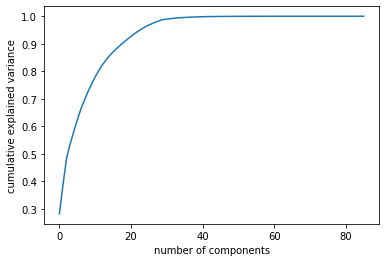

In [73]:
#PCA to minimize multicollinearity
pca = PCA().fit(df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

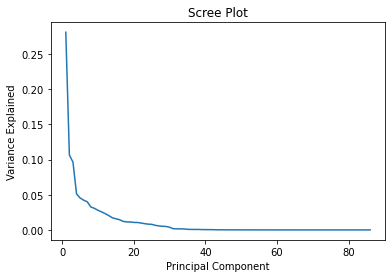

In [74]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [75]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)
df_pca = pd.DataFrame(pca.fit_transform(df))
df_pca['GAME_ID'] = df_game_ids
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,GAME_ID
0,7.890631,0.914249,-3.544050,-0.218901,0.788576,-0.294968,1.551861,-3.226709,-0.547657,0.791083,...,1.690773,-2.397474,1.097709,0.795858,-1.625666,-0.534747,-0.446155,-1.686147,0.624870,42100404
1,7.818492,1.486399,-3.691290,0.224855,0.316881,-0.237816,1.256386,-2.890445,-0.197480,0.693942,...,1.464752,-2.255365,1.018134,1.147306,-1.250246,-0.629518,-0.713867,-1.490611,0.560057,42100403
2,8.772407,-0.944049,-4.307018,0.300679,-0.502055,0.144257,-1.387709,-2.794222,0.421266,0.552209,...,2.007157,2.376958,-1.132203,1.007452,0.837872,-0.618636,1.369380,-0.401291,-0.091793,42100402
3,8.896206,-1.771368,-4.416812,0.713211,-0.187256,0.123317,-1.050993,-2.978331,0.715750,0.898884,...,1.896024,2.331435,-1.119754,1.167161,0.858590,-0.678950,1.345690,-0.366364,0.094953,42100401
4,5.968266,1.989999,-3.014090,-0.946734,0.031070,0.308159,1.253381,-0.694537,-1.520278,1.120428,...,0.439385,0.722995,0.144178,0.534497,1.069302,-2.761659,2.150393,0.760658,-0.326341,42100307


In [77]:
#split pca data into train and test
test_game_ids = set(test_spreads_df['GAME_ID'])
X_train_pca = df_pca[~df_pca['GAME_ID'].isin(test_game_ids)].copy()
X_test_pca = df_pca[df_pca['GAME_ID'].isin(test_game_ids)].copy()

train_pca_game_ids = X_train_pca['GAME_ID'].copy()
test_pca_game_ids = X_test_pca['GAME_ID'].copy()

X_train_pca.drop(columns=['GAME_ID'], inplace=True)
X_test_pca.drop(columns=['GAME_ID'], inplace=True)

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6246,10.334760,-3.035556,-5.762777,0.791876,0.603740,1.677426,-0.971201,-0.979342,0.987292,0.659481,3.493599,-0.830872,-0.733806,1.137703,-0.124193,-0.800268,0.749547,-0.200892,-0.417786,-0.416648
6247,10.277482,4.120301,-5.793056,0.951588,-0.580984,0.972478,0.994474,-1.150092,-1.306440,0.442988,-3.305627,-1.164141,0.826907,-1.225470,-0.020223,0.395499,0.896433,0.351772,-0.115964,-0.903523
6248,10.691133,3.989783,-6.522520,1.183154,-0.205981,0.825011,1.316043,-0.913150,-1.304591,0.514258,-3.147544,-1.010514,0.859033,-1.309479,-0.088937,0.224878,0.889956,0.664979,-0.209564,-0.791914
6249,10.502489,-3.313194,-7.031221,0.945990,-0.002090,0.578531,-1.262648,-1.004499,0.605046,1.261251,3.539476,-0.958507,-1.056470,1.736448,-0.401205,0.193115,0.981354,-0.290058,-0.914403,-0.218279
6250,10.767869,-2.412252,-7.516615,0.683735,0.237189,1.097758,-1.244122,-1.634368,1.061566,1.526339,2.989571,-0.480366,-1.028261,1.499909,-0.788697,0.011180,0.636643,-0.481357,-1.319286,-0.169561


In [ ]:
#polynomial regression using polynomial features of degree 2
degree = 2
poly=PolynomialFeatures(degree)



In [165]:
#import betting spreads data
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [172]:
#Tuned RF
#create hyperparameter grid
'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(100, 1000, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''

"\nrf = RandomForestRegressor()\nn_estimators = [int(x) for x inn np.linspace(100, 1000, num=10)]\nmax_features =['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 50, num=10)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 5]\nbootstrap = [True, False]\n\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=31, n_jobs=-1)\n\nrf_random.fit(X_train, y_train)\n"